### Epf filing compliance score
info.json has epf transactions as well as employee names across months for a party. <br>
Normally, EPF filing is to be done by the end of the next month of the wage month. Else, it is considered non-compliant.

Hence we take the gap between salary month and epf filing date

In [1]:
import numpy as np
import pandas as pd
import json
from pandas.io.json import json_normalize

pd.options.display.max_columns = None
#pd.set_option('display.max_columns', 50)

#### Reading the 3 json files into dataframe

In [2]:
# deser. from json to python data structure (here, list of dict)
lines = [json.loads(line) for line in open('./data/parties.json', 'r', encoding='utf8')]
party_df = json_normalize(lines)
print("Party", party_df.shape)

lines = [json.loads(line) for line in open('./data/registrations.json', 'r', encoding='utf8')]
reg_df = json_normalize(lines)
print("Registrations", reg_df.shape)

lines = [json.loads(line) for line in open('./data/information.json', 'r', encoding='utf8')]
info_df = json_normalize(lines)
print("Informations", info_df.shape)

Party (14804, 162)
Registrations (15000, 48)
Informations (148259, 25)


#### Merging of reg and info data  based on reg_id and info_id

In [3]:
#reg_info_df = pd.merge(reg_df, info_df, how='outer', left_on=['party_id.$oid', '_id.$oid'], right_on=['party_id.$oid', 'registration_id.$oid'], suffixes=('','_y'))
reg_info_df = pd.merge(reg_df, info_df, how='outer', left_on='_id.$oid', right_on='registration_id.$oid', suffixes=('','_y'))

print("Merged datframe", reg_info_df.shape)
print("Merged columns", reg_info_df.columns)

Merged datframe (157229, 73)
Merged columns Index(['_type', '_ref', '_model_type', 'normalized_name', 'aliases',
       'has_anomaly', 'acc', 'city', 'country', 'epfo_office',
       'epfo_office_address', 'pin_code', 'primary_business_activity', 'ro',
       'section_applicable', 'state', 'version', 'name', 'nationality',
       '_id.$oid', 'updated_at.$date', 'party_id.$oid', 'sources.in_gov_epf',
       'bots.in_gov_epf_epf_excel_search', 'bots.in_gov_epf_epf_blob_search',
       'anomalies', 'status', 'old_party_id.$oid', 'sources.in_gov_mca',
       'bots.in_src_woi_woi_search', 'bots.in_gov_mca_upload_documents',
       'cia_party', 'bots.in_gov_nsdl_full_refresh', 'exemption_status',
       'working_status', 'coverage_section', 'actionable_status',
       'date_of_coverage', 'bots.in_gov_rbi_ecb_full_refresh', 'yes_bank',
       'district', 'rbl', 'bots.in_gov_gstn_gstn_search', 'sources.in_src_woi',
       'bots.in_gov_mca_company_documents', 'sources.in_gov_nsdl', 'party_id',


#### Select columns for epf filing

In [4]:
cols_to_keep = ['party_id.$oid', 'wage_month', 'credit_date']
epf_df = reg_info_df.filter(cols_to_keep, axis=1)

epf_df.rename(columns = {'party_id.$oid':'party_id'}, inplace = True) 
# 5.7% data was missing
epf_df.dropna(subset=['credit_date', 'wage_month'], inplace=True)
print("Merged datframe with selected columns", epf_df.shape, epf_df.columns)

Merged datframe with selected columns (148259, 3) Index(['party_id', 'wage_month', 'credit_date'], dtype='object')


In [5]:
from datetime import datetime

def format_convert_col(str_list):
    dates = []
    
    for s in str_list:
        if s.find('-') != -1:
            d = datetime.strptime(s, '%b-%y') # NOV-17
            #print("if", d)
        else:
            d = datetime.strptime(s, '%m%Y') # 052016
            #print("else", d)
        dates.append(d)
    return dates

def format_convert_col2(str_list):
    dates = []
    
    for s in str_list:
        if s.find(':') != -1:
            s = s.split()[0]
            # check for letters in s
            if any(c.isalpha() for c in s) :
                d = datetime.strptime(s, '%d-%b-%Y') # 26-AUG-2017 05:54:35      
            else :
                d = datetime.strptime(s, '%Y-%m-%d') #2016-05-26 00:00:00 UTC
        else:
            d = datetime.strptime(s, '%Y-%m-%d') # 2018-01-25    
        dates.append(d)        
    return dates

#dList = format_convert_col2(epf_df['credit_date'].tolist())

#### Converting columns 'wage_month', credit_date of diff. formats to a common format of type datetime.datetime

In [6]:
wageDates = format_convert_col( epf_df['wage_month'].tolist() )
epfDates = format_convert_col2( epf_df['credit_date'].tolist() )

epf_df['wage_date'] = wageDates
epf_df['epf_date'] = epfDates
epf_df.drop(['wage_month'], axis=1, inplace=True)
epf_df.drop(['credit_date'], axis=1, inplace=True)

- <b>Sort on some columns
- Set index </b>
Can be run once

In [7]:
epf_df.sort_values(by=['party_id', 'wage_date'], inplace=True)
epf_df.set_index(['party_id', 'wage_date'], inplace=True)

print("INDEX", epf_df.index.names)
print(epf_df.columns)

#epf_df.to_csv("epf.csv")
epf_df.loc['5559286e6d6f6f270e4f6d05', '2016-12-01']

INDEX ['party_id', 'wage_date']
Index(['epf_date'], dtype='object')


epf_date
party_id                 wage_date            
5559286e6d6f6f270e4f6d05 2016-12-01 2017-01-20
                         2016-12-01 2017-01-20

#### Epf filing on monthly basis
There are multiple entries for a (party, wage_date), as seen above

In [8]:
# aggSeries of type Series of size 111584, reduced from 148259
aggSeries = epf_df.groupby(by = ['party_id', 'wage_date'])['epf_date'].agg('first')
print(aggSeries.index.names, aggSeries.shape)

aggSeries.loc['5559286e6d6f6f270e4f6d05', '2016-12-01']

['party_id', 'wage_date'] (111584,)


Timestamp('2017-01-20 00:00:00')

#### aggSeries converted to dataframe without index

In [9]:
epf_agg_df = aggSeries.to_frame()
epf_agg_df.reset_index(inplace=True)

print(epf_agg_df.shape, epf_agg_df.index.names)
print( epf_agg_df.columns)
epf_agg_df.to_csv("epf_agg.csv")

(111584, 3) [None]
Index(['party_id', 'wage_date', 'epf_date'], dtype='object')


#### Computation of aggregate values

In [10]:
# Series of type Timedelta
time_period = epf_agg_df['epf_date'] - epf_agg_df['wage_date']

# Series of type numpy.int64
epf_agg_df['time_gap'] = pd.to_timedelta(time_period, errors='coerce').dt.days - 30

epf_agg_df.head()

,party_id,wage_date,epf_date,time_gap
0,54f079716d6f6f6a52582a00,2016-10-01,2017-02-14,106
1,54f079716d6f6f6a52582a00,2016-11-01,2017-02-14,75
2,54f079716d6f6f6a52582a00,2016-12-01,2017-02-14,45
3,54f079716d6f6f6a52582a00,2017-01-01,2017-02-14,14
4,54f079716d6f6f6a52582a00,2017-02-01,2017-04-21,49


#### Comput epf_compliance of each epf transaction 
Score is 0 / 1

In [11]:
epf_agg_df['epf_compliance'] = np.where(epf_agg_df['time_gap'] > 30, 0, 1)
epf_agg_df.head()

,party_id,wage_date,epf_date,time_gap,epf_compliance
0,54f079716d6f6f6a52582a00,2016-10-01,2017-02-14,106,0
1,54f079716d6f6f6a52582a00,2016-11-01,2017-02-14,75,0
2,54f079716d6f6f6a52582a00,2016-12-01,2017-02-14,45,0
3,54f079716d6f6f6a52582a00,2017-01-01,2017-02-14,14,1
4,54f079716d6f6f6a52582a00,2017-02-01,2017-04-21,49,0


#### Compute compliance score of each party by taking mean

In [14]:
compliance_avg = epf_agg_df.groupby(by = ['party_id'])['epf_compliance'].agg('mean')
compliance_avg[:10]

party_id
54f079716d6f6f6a52582a00    0.684211
54f219a56d6f6f1be7939b01    1.000000
555074f66d6f6f21df940300    1.000000
555075896d6f6f2192660500    0.722222
55507eed6d6f6f21923b2600    0.789474
55507ef56d6f6f2192572600    1.000000
55507f3c6d6f6f2192752700    0.200000
555080606d6f6f21df822800    0.000000
555086d06d6f6f21dff23700    0.944444
555087366d6f6f21df483900    0.555556
Name: epf_compliance, dtype: float64

#### Histogram of freq of parties wrt compliance score

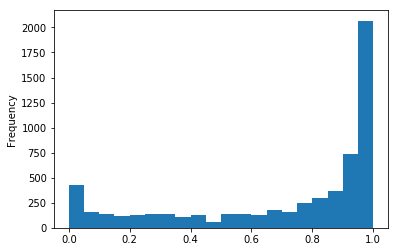

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

compliance_avg.plot.hist(bins=20)